In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


microsoft_data=pd.read_csv('Microsoft_Data.csv')

y=microsoft_data['HasDetections']

microsoft_data.drop(columns='HasDetections',inplace=True)

# code to get the missing value count for each variable
missing_value_percentage_df=pd.DataFrame({'Column_Name':microsoft_data.columns,
                                          'Missing_value_count':microsoft_data.isnull().sum(),
                                          'Missing_value_percentage':microsoft_data.isnull().sum()/microsoft_data.shape[0]*100})

missing_value_percentage_df=missing_value_percentage_df.sort_values(by='Missing_value_percentage',ascending=False)


In [2]:
cols_to_drop=[]

cols_with_missing_values_grt_50=list(missing_value_percentage_df[missing_value_percentage_df['Missing_value_percentage']>50].index)

for col in microsoft_data.columns:
    if microsoft_data[col].nunique() == microsoft_data.shape[0] or microsoft_data[col].nunique()==1:
        cols_to_drop.append(col)
        

columns_to_drop=cols_to_drop + cols_with_missing_values_grt_50

microsoft_data.drop(columns = columns_to_drop,inplace=True)


In [3]:
for col in microsoft_data.columns:
    if col!='Census_SystemVolumeTotalCapacity':
        microsoft_data[col]=microsoft_data[col].astype(object)
        
microsoft_data['Census_SystemVolumeTotalCapacity'].dtype


dtype('float64')

In [4]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(microsoft_data,y,test_size=0.2,random_state=43)

# Filling missing values

for col in X_train.columns:
    if X_train[col].dtype =='object':
        X_train[col] = X_train[col].fillna(X_train[col].mode()[0]).astype(object)
        X_test[col]=X_test[col].fillna(X_train[col].mode()[0]).astype(object)
        
    else:
        X_train[col]=X_train[col].fillna(X_train[col].mean())
        X_test[col]=X_test[col].fillna(X_train[col].mean())

  

In [5]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [6]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoderExt()

for col in X_train.columns:
    if X_train[col].dtype=='object':
        le.fit(X_train[col])
        X_train[col]=le.transform(X_train[col])
        X_test[col]=le.transform(X_test[col])

In [7]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()

logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

In [8]:
comparisons_df=pd.DataFrame({'Actuals':y_test,'Predictions':y_pred})

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

confusion_matrix(y_test,y_pred)

recall_score(y_test,y_pred)
precision_score(y_test,y_pred)

f1_score(y_test,y_pred)

0.5583126550868486

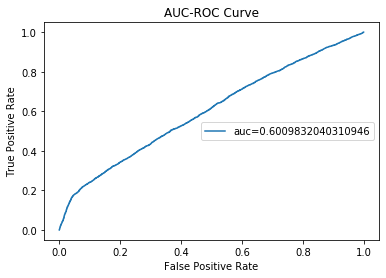

In [9]:
y_pred_prob = logreg.predict_prob(X_test)[::,1]

y_pred_prob

fpr,tpr,thresholds=roc_curve(y_test,y_pred_prob) # the function roc_curve returns three values, the False Positive Rate,True Positive rate
                                                # threshold values it used to calculate the TPR and FPR

auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')

plt.legend(loc=5)
plt.show()

In [10]:
scores_df=pd.DataFrame({'FPR':fpr,'Thresholds':thresholds})
scores_df


,FPR,Thresholds
0,0.000000,1.693535
1,0.000000,0.693535
2,0.000000,0.671239
3,0.000178,0.671113
4,0.000178,0.660955
...,...,...
5398,0.999467,0.340130
5399,0.999822,0.334909
5400,0.999822,0.319445
5401,1.000000,0.319263


In [11]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
y_nb_pred = mnb.predict(X_train)
y_pred

array([0, 0, 1, ..., 1, 0, 0])

In [12]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

confusion_matrix(y_test,y_pred)

recall_score(y_test,y_pred)
precision_score(y_test,y_pred)


0.5666486778197517

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score #works

clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred_dt = clf.predict(X_test)# while predicting we only need i/p data
y_pred_dt
print("Accuracy:",accuracy_score(y_test, y_pred_dt))


Accuracy: 0.5513565891472868


In [18]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

confusion_matrix(y_test,y_pred_dt)

recall_score(y_test,y_pred_dt)
precision_score(y_test,y_pred_dt)


0.5544639779386419

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest  = RandomForestClassifier()
forest.fit(X_train,y_train)
y_predict_forest = forest.predict(X_test)
y_predict_forest

array([0, 0, 0, ..., 0, 1, 0])

In [21]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

confusion_matrix(y_test,y_predict_forest)

print(recall_score(y_test,y_predict_forest))

print(precision_score(y_test,y_predict_forest))

0.48611353711790395
0.5863885377159713


In [22]:
from sklearn.ensemble import AdaBoostClassifier
adapt = AdaBoostClassifier()
adapt.fit(X_train,y_train)
y_predict_adapt = adapt.predict(X_test)
y_predict_adapt

array([0, 0, 0, ..., 1, 1, 1])

In [23]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

confusion_matrix(y_test,y_predict_adapt)

print(recall_score(y_test,y_predict_adapt))

print(precision_score(y_test,y_predict_adapt))

0.5540611353711791
0.617601246105919


In [ ]:
# kaggle allstate claims severity